### Туториал с адаптивным RAG 

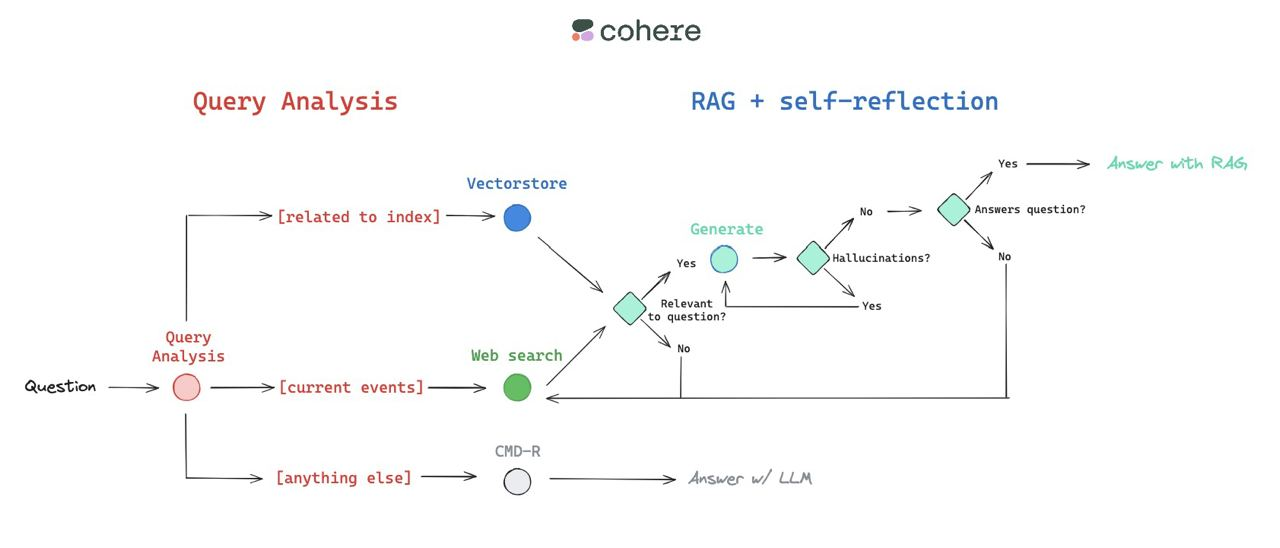

https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_adaptive_rag_cohere.ipynb

### LangChain Smith

https://smith.langchain.com/o/36e8db4d-179b-55cd-8b91-3d28c17b9551/settings/workspaces/members

# TODO: 

- Разобраться с RecursiveSplitter


In [35]:
import os
from pathlib import Path
from typing import List

from transformers import AutoTokenizer, AutoModel

import torch

from langchain.text_splitter import CharacterTextSplitter
from langchain_cohere import CohereEmbeddings
from langchain_community.vectorstores import Chroma, FAISS

from langchain_community.document_loaders import TextLoader
from langchain.schema import Document


import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel

In [26]:
from transformers import AutoTokenizer
# from ragatouille import RAGPretrainedModel
from langchain.docstore.document import Document
from langchain.prompts.prompt import PromptTemplate
from langchain_core.runnables import ConfigurableField
from langchain_community.vectorstores import FAISS, Chroma
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DataFrameLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

### Tokenizer and Embedder

In [29]:
EMBEDDING_MODEL_NAME = 'intfloat/multilingual-e5-large'
CHUNK_SIZE = 512 

In [36]:
# Укажите название модели
model_name = "intfloat/multilingual-e5-large"

# Загрузите модель и токенизатор
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Укажите путь, куда вы хотите сохранить модель и токенизатор
save_directory = "./multilingual-e5-large"

# Сохраните модель и токенизатор на локальном диске
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Модель и токенизатор сохранены в {save_directory}")

Модель и токенизатор сохранены в ./multilingual-e5-large


In [37]:
from transformers import AutoModel, AutoTokenizer

# Укажите путь к директории, где сохранена модель и токенизатор
load_directory = "./multilingual-e5-large"

# Загрузите модель и токенизатор из сохранённой директории
model = AutoModel.from_pretrained(load_directory)
tokenizer = AutoTokenizer.from_pretrained(load_directory)

# Пример использования модели и токенизатора
input_text = "Пример текста для токенизации"
inputs = tokenizer(input_text, return_tensors="pt")

# Прогоните входные данные через модель
outputs = model(**inputs)

# Получите эмбеддинги или другие выходные данные модели
embeddings = outputs.last_hidden_state
print(embeddings)

tensor([[[ 0.3606, -0.3497, -0.8130,  ...,  0.3058, -1.1112,  0.0711],
         [ 0.7147, -0.2114, -0.9025,  ...,  0.3682, -1.1603, -0.5250],
         [ 0.5071, -0.5180, -0.8398,  ...,  0.0476, -1.0611, -0.3901],
         ...,
         [ 0.6375, -0.3680, -0.4641,  ..., -0.0624, -1.0005,  0.2080],
         [ 0.4823, -0.3093, -0.8309,  ..., -0.1291, -0.7912, -0.2292],
         [ 0.3606, -0.3497, -0.8128,  ...,  0.3057, -1.1111,  0.0710]]],
       grad_fn=<NativeLayerNormBackward0>)


In [30]:
from typing import Optional, List

In [31]:
import time

In [32]:
%%time 

time.sleep(2)

CPU times: user 893 μs, sys: 1.49 ms, total: 2.38 ms
Wall time: 2 s


In [34]:
%%time 



def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


# Each input text should start with "query: " or "passage: ", even for non-English texts.
# For tasks other than retrieval, you can simply use the "query: " prefix.
input_texts = ['query: how much protein should a female eat',
               'query: 南瓜的家常做法',
               "passage: As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
               "passage: 1.清炒南瓜丝 原料:嫩南瓜半个 调料:葱、盐、白糖、鸡精 做法: 1、南瓜用刀薄薄的削去表面一层皮,用勺子刮去瓤 2、擦成细丝(没有擦菜板就用刀慢慢切成细丝) 3、锅烧热放油,入葱花煸出香味 4、入南瓜丝快速翻炒一分钟左右,放盐、一点白糖和鸡精调味出锅 2.香葱炒南瓜 原料:南瓜1只 调料:香葱、蒜末、橄榄油、盐 做法: 1、将南瓜去皮,切成片 2、油锅8成热后,将蒜末放入爆香 3、爆香后,将南瓜片放入,翻炒 4、在翻炒的同时,可以不时地往锅里加水,但不要太多 5、放入盐,炒匀 6、南瓜差不多软和绵了之后,就可以关火 7、撒入香葱,即可出锅"]

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T) * 100
print(scores.tolist())

[[90.81391906738281, 72.1339111328125], [70.5354232788086, 88.76109313964844]]
CPU times: user 12.4 s, sys: 2.5 s, total: 14.9 s
Wall time: 6.59 s


In [6]:


# def average_pool(last_hidden_states,
#                  attention_mask):
#     last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
#     return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

# tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
# model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

# def get_batch_dict(input_texts, MAX_LENGTH):
#     batch_dict = tokenizer(input_texts, max_length=MAX_LENGHT, padding=True, truncation=True, return_tensors='pt')
#     return batch_dict

# outputs = model(**batch_dict)
# embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# # normalize embeddings
# embeddings = F.normalize(embeddings, p=2, dim=1)
# scores = (embeddings[:2] @ embeddings[2:].T) * 100
# print(scores.tolist())


In [7]:
# model_name = 'DeepPavlov/rubert-base-cased-sentence'

# # to try: e5 multilanguage

# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

### Index

In [ ]:
# text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
#     AutoTokenizer.from_pretrained(tokenizer_name),
#     chunk_size=chunk_size,
#     chunk_overlap=int(chunk_size / 10),
#     add_start_index=True,
#     strip_whitespace=True,
# )

___

In [14]:
def split_documents(
    chunk_size,
    doc,
    tokenizer_name
) -> List[Document]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 5),
        add_start_index=True,
        strip_whitespace=True,
    )

    doc_processed = text_splitter.split_documents([doc])

    return doc_processed

In [16]:
gp_folder = "/Users/user03/Desktop/PETs/LegalAI/data/codex/Гражданский кодекс"

In [24]:
docs = []

for file_i in Path(gp_folder).iterdir():
    loader_i = TextLoader(file_i)
    documents_i = loader_i.load()
    docs_i = split_documents(CHUNK_SIZE, documents_i[0], EMBEDDING_MODEL_NAME)
    docs.extend(docs_i)
    
docs_part = docs[:10]

KeyboardInterrupt: 

In [19]:
docs = []

for file_i in Path(gp_folder).iterdir():
    loader_i = TextLoader(file_i)
    documents_i = loader_i.load()
    docs_i = text_splitter.split_documents(documents_i)
    docs.extend(docs_i)
    
docs_part = docs[:10]

AttributeError: 'list' object has no attribute 'page_content'

In [201]:
model_name = 'DeepPavlov/rubert-base-cased-sentence'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

class RuBERTaEmbeddings:
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer
        self.model = model
        
    def embed(self, documents: List) -> List[List[float]]:
        
        embeddings = []
        for doc in documents:
            inputs = self.tokenizer(doc, return_tensors='pt', truncation=True, padding=True, max_length=2048)
            with torch.no_grad():
                outputs = self.model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze().tolist()
            embeddings.append(embedding)
            
        return embeddings   

    def embed_documents(self, documents):
        return self.embed(documents)
    
    def embed_query(self, text) -> List[float]:
        return self.embed([text])[0]
        
embd = RuBERTaEmbeddings(tokenizer, model)

In [203]:
db = Chroma.from_documents(docs_part, embd)

# to try: FAISS 

retriever = db.as_retriever()

### LLMs

In [192]:
from langchain import OpenAI
from langchain.chains import RetrievalQA